## How To Convert Log-Mel features back to audio waveform using TorchAudio

This will be a short post on how to convert frequency domain log-Mel features back to time-domain waveform, basically inverting or reversing the feature processing. In the feature processing, there are a couple of steps:  
1. **STFT**: Short-time Fourier Transform or in otherwords we apply window (hann window) to overlapping (50% overlap) frames of the waveform and then take the FFT. The window size or frame size is usually the FFT size.

2. **Magnitude Spectrogram**: For real data, the Fourier Transform is symmetric, so we only need to keep NFFT/2 + 1 bins. To get the spectrogram, we take the magnitude squared of each bin. We should note that by taking magnitudes, we are throwing away phase information. It is generally assumed (?) that phase information is less important than magnitude as far as recognition tasks go (TBD: please find a reference for this claim)

3. **Mel Filterbank**: computes weighted averages of bins to provide spectral power estimates on a logarithmic frequency scale which is more inline with human hearing resolution. The bottom line is that this is also a step where information is thrown away and only that which is relevant to the task is kept.

4. **Linear to dB**

If we need to invert the feature processing, we need to apply the inverse of each operation:  
1. **dB to Linear**
2. **Inverse Mel filterbank**: requires that we go from a 64 dimensional vector (the number of Mel frequencies we have been using) to a 161 dimensional spectrogram (assuming a FFT size of 320). A simple approach is to multiply by the transpose of the Mel matrix weighting. A better approach is to use the pseudoinverse of the Mel matrix. An even better approach is to solve a non-linear least square problem to find the magnitudes. This is the approach taken in TorchAudio, if I am not mistaken.
3. **ISTFT and Griffin-Lim**: If we had the phase available, we can take ISTFT (overlap and add procedure) and we can call it a day. But since we are interested in what to do when the phase is not available, we need to use another algorithm called the Griffin-Lim algorithm to iteratively recover the phase. Basically, the procedure is to iteratively take ISTFT (with some initial phase), followed by STFT and then applying the target magnitude. There are also alternative approaches to recover phase such as [Local Weighted Sums](https://pypi.org/project/lws/)

In [1]:
# CUSTOMARY IMPORTS
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import os
import librosa # only for loading/plotting utilities
import librosa.display

from jumpml import models
from jumpml import eval
from jumpml import SpeechCommandsDataset as scd
from jumpml import utils

import itertools
from IPython.display import Audio

import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 1        
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', device)

Using cpu


#### LOAD TEST CASE

In [2]:
testFiles = utils.get_filenames('files',searchstr='SCRIC20*')
idx = 1  # change this from 0 to 19
orig_waveform, sr = torchaudio.load(testFiles[idx])
X = scd.preprocess_waveform(orig_waveform, padLR=False)   # LogMel features

## Inverse Transforms in TorchAudio
Thankfully, we don't have to do a lot of work since TorchAudio (may be librosa) has already done the hard parts for us. The only thing we need to do is to write a *custom transform* for converting dB to linear Amplitude. Basically it's just a function that is part of a class of type nn.Module. Once this part is done, we chain together the transforms in the order mentioned in the intro. 

In [3]:
class dB_to_Amplitude(nn.Module):
    def __call__(self, features):
        return(torch.from_numpy(np.power(10.0, features.numpy()/10.0)))

def get_waveform_from_logMel(features, n_fft=320, hop_length=160, sr = 16000):
    n_mels = features.shape[-2]
    inverse_transform = torch.nn.Sequential(
            dB_to_Amplitude(),
            torchaudio.transforms.InverseMelScale(n_stft=n_fft//2+1, n_mels=n_mels, sample_rate=sr),
            torchaudio.transforms.GriffinLim(n_fft=320, hop_length=160)
            )
    waveform = inverse_transform(torch.squeeze(features))
    return torch.unsqueeze(waveform,0)
    

#### LOG-MEL TO WAVEFORM

In [4]:
waveform = get_waveform_from_logMel(X)

/Users/ragh/anaconda3/lib/python3.6/site-packages/torchaudio/functional.py:110: UserWarning: istft has been moved to PyTorch and will be removed from torchaudio, please use torch.istft instead.
  'istft has been moved to PyTorch and will be removed from torchaudio, '


#### VISUALLY PRETTY CLOSE

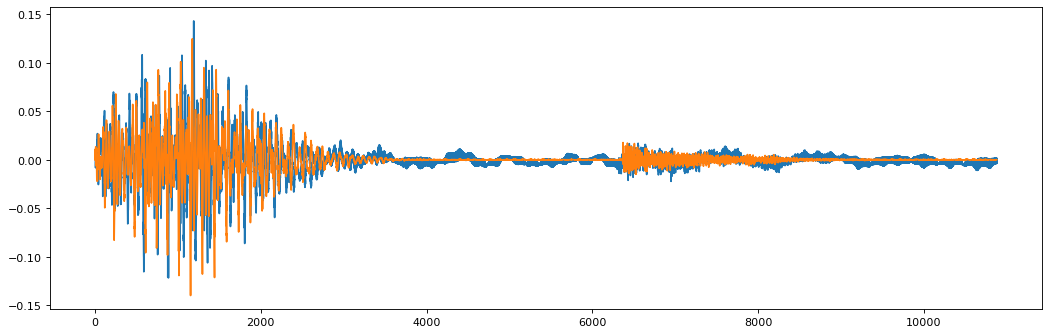

In [5]:
fig=plt.figure(figsize=(16, 5), dpi=80)
plt.plot(torch.squeeze(waveform)[:orig_waveform.shape[1]])
plt.plot(torch.squeeze(orig_waveform))

#### SOUNDS CLOSE

In [6]:
print("Reconstruction:")
Audio(waveform,rate=sr)

Reconstruction:


In [7]:
print("Original:")
Audio(orig_waveform,rate=sr)

Original:


#### LETS LOOK AT LOG-MEL SPECTROGRAMS

Text(0.5, 1.0, 'Reconstruction')

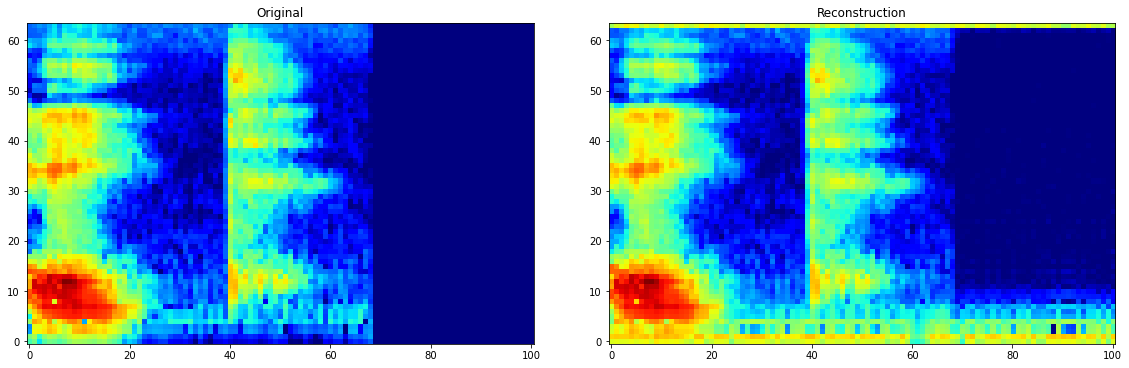

In [8]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16, 5))
axs[0].imshow(torch.squeeze(X), cmap='jet', origin='lower')
axs[0].set_title('Original')
axs[1].imshow(torch.squeeze(scd.preprocess_waveform(waveform, padLR=False) ), cmap='jet', origin='lower')
axs[1].set_title('Reconstruction')

## Conclusion
We inverted Log-Mel features using a combination of TorchAudio transforms. 

There is an issue though, it seems like there is some garbage at the highest frequency and lower frequency (look where there is supposed to be silence). May be I have a bug somewhere. I mostly wanted to do this for debugging, listening to Mel Spectrograms or modified/filtered Mel Spectrograms to see what is going on.